<font color='blue'> **Zahasky_07_________________b_________________** </font> 

In [1]:
import sys; import flopy; import os; import time; import numpy as np  ; import matplotlib.pyplot as plt ; from pathlib import Path; import pandas as pd; import string ; 
from scipy.special import erfc as erfc   ; from scipy.special import erf as erf ; EXF = 'E:\\15_REPOS\\00_BETAMI\\bin\\MF2005.exe'    ; EXT = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64.exe'
import flopy.utils.binaryfile as bf      ; _R=Path("_R"); _R.mkdir(exist_ok=True); TA=Path("_R/_07"); TA.mkdir(exist_ok=True)  ;TB=Path(TA/"TB"); TB.mkdir(exist_ok=True)
from copy import deepcopy as deepcopy    # (https://www.sciencedirect.com/science/article/abs/pii/S0169772212000599)

In [ ]:
delc=0.03 ; RO_S=0.4 ; RO_C=0.5     ; K_S  = 2.4e-4*86400       ; K_C   = 1e-10*86400

L=40 ;R=1 ;C=120  ;delv=delr=0.01  ;MAT=np.zeros([L,R,C])   ;MAT[10:20,:,15:-15]=1  ;HK=np.ones([L,R,C])*K_S ;RO=np.ones([L,R,C])*RO_S  ;HK[MAT==1]=K_C  ;RO[MAT==1]=RO_C   # ____ A
L= 8 ;R=1 ;C= 24  ;delv=delr=0.05  ;MAT=np.zeros([L,R,C])   ;MAT[ 2: 4,:, 3:- 3]=1  ;HK=np.ones([L,R,C])*K_S ;RO=np.ones([L,R,C])*RO_S  ;HK[MAT==1]=K_C  ;RO[MAT==1]=RO_C   # ____ B
L=20 ;R=1 ;C= 40  ;delv=delr=0.01  ;MAT=np.zeros([L,R,C])   ;MAT[ 5:10,:, 7:- 8]=1  ;HK=np.ones([L,R,C])*K_S ;RO=np.ones([L,R,C])*RO_S  ;HK[MAT==1]=K_C  ;RO[MAT==1]=RO_C   # ____ C

nlay=L;nrow=R;ncol=C ;    PERLEN=[10,22,50] ; NPER=len(PERLEN) ;NPRS = 100   ;TIMPRS=np.linspace(0,np.sum(PERLEN),NPRS,endpoint=False)    ;itmuni=4;MT_tunit='D';lenuni=2;MT_lunit='M' 

hk_size=HK.shape  ; nlay=hk_size[0]  ;nrow=hk_size[1]   ;ncol = hk_size[2]  ;botm = -np.linspace(delv, delv*nlay, nlay)        ;SF= nlay * delv / 0.84      ; DISP = 0.01; trpv = 0.001/DISP
ibound = np.ones((nlay,nrow,ncol), dtype=int)   ;ibound[:, :, -1] = -1      ;IC = np.zeros((nlay, nrow, ncol), dtype=float)    ;Q = np.array([0.9, 1.5, 1.5])*(60*24/100**3)*SF      


W01  = np.zeros((nlay, 4),dtype=float)  ;W01[:,0] = range(0, nlay)   ; W01[:,3] = Q[0] / (nrow * nlay)   ; w = deepcopy(W01)   ; WF_S = { 0 : w }   # CC|W ___________________________________
for i in range(1, NPER):
    if isinstance(Q, (list, tuple, np.ndarray)):  W01[:,3] = Q[i]/(nrow * nlay)
    else:                                         W01[:,3] = Q   /(nrow * nlay)     ; w = deepcopy(W01)   ; WF_S.update({i:w})                      # ________________________________ A
Cinj = [1, 0, 0] ;   D0 = 13E-10 * 86400    ; icbund = np.ones((nlay, nrow, ncol), dtype=int)   ; sconc = np.zeros((nlay, nrow, ncol), dtype=float) 
W02 = np.zeros((int(nlay), 5), dtype=float) ; W02[:,0] = range(0, nlay)  ; W02[:,3] = Cinj[0]   ;itype = 2  ; W02[:,4] = int(itype)  ; cw = deepcopy(W02) ; WT_S = { 0 : cw }
for i in range(1,NPER):
    if isinstance(Cinj, (list, tuple, np.ndarray)):     W02[:,3] = Cinj[i]                    
    else:                                               W02[:,3] = Cinj      ; cw = deepcopy(W02)         ; WT_S.update({i:cw})                     # ________________________________ B

In [3]:
OC_S = {(0, 0): ['save head'], (0, 1): ['save head'], (0, 2): ['save head'], (0, 3): ['save head']}

MF  = flopy.modflow.Modflow    (modelname='MF', model_ws=TA, exe_name=EXF)
dis = flopy.modflow.ModflowDis (MF,  nlay = nlay, nrow=nrow, ncol=ncol, nper=NPER, delr=delr, delc=delc, top=0., botm = botm ,perlen=PERLEN, itmuni=itmuni, lenuni=lenuni)
bas = flopy.modflow.ModflowBas (MF, ibound=ibound, strt=IC)   ; lpf = flopy.modflow.ModflowLpf (MF, hk=HK, laytyp=0) ; 
wel = flopy.modflow.ModflowWel (MF, stress_period_data=WF_S)  ; pcg = flopy.modflow.ModflowPcg (MF, rclose=1.0e-5, mxiter=100, iter1=50)
lMT = flopy.modflow.ModflowLmt (MF)                           ; oc  = flopy.modflow.ModflowOc  (MF, stress_period_data=OC_S)    ; MF.write_input() ; MF.run_model(silent=True) 

MT  = flopy.mt3d.Mt3dms(modelname='MT', model_ws=TA, exe_name=EXT, modflowmodel=MF)  
btn = flopy.mt3d.Mt3dBtn(MT, icbund=icbund, prsity=RO, sconc=sconc, tunit=MT_tunit, lunit=MT_lunit, nper=NPER, perlen=PERLEN, nprs=NPRS, timprs=TIMPRS)  ;mixelm = -1
adv = flopy.mt3d.Mt3dAdv(MT, mixelm=mixelm)                   ; dsp = flopy.mt3d.Mt3dDsp (MT, al=DISP, trpv =trpv, dmcoef=D0)                        
ssm = flopy.mt3d.Mt3dSsm(MT, stress_period_data=WT_S)         ; gcg = flopy.mt3d.Mt3dGcg (MT)                                 ; MT.write_input() ; MT.run_model(silent=True)

(False, [])

In [4]:
ucnobj = flopy.utils.UcnFile(os.path.join(TA, 'MT3D001.UCN'))   ; times = np.array(ucnobj.get_times())  ;conc = ucnobj.get_alldata()
h = flopy.utils.HeadFile(os.path.join(TA/'MF.hds'), model=MF)   ; hdobj=flopy.utils.HeadFile(os.path.join(TA/'MF.hds'))  ;heads=hdobj.get_data()
print('H:',heads.shape ,'______C:', conc.shape)

H: (20, 1, 40) ______C: (103, 20, 1, 40)


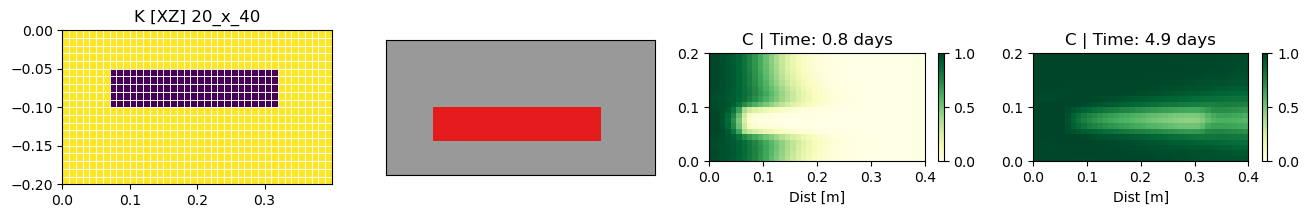

In [53]:
fig = plt.figure(figsize=(16, 2))    
ax=fig.add_subplot(141) ;SX=flopy.plot.PlotCrossSection(model=MF,line={'Row':0}) ;VK=SX.plot_array(HK) ;SX.plot_grid(colors='white',lw=0.5) ;plt.title('K [XZ] '+ '%1.0f' %(nlay) +'_x_'+'%1.0f' %(ncol))

ax=fig.add_subplot(142) ;MP = np.squeeze(HK)                               ;r,c=np.shape (MP)               ;XX=np.linspace(0,delv*c,c+1);YY=np.linspace(0,delr*r,r+1);X,Y=np.meshgrid(XX,YY)
n='n'                   ;plt.pcolormesh(X,Y,MP,cmap='Set1')                ;plt.gca().set_aspect('equal')   ;ax.xaxis.set_visible(False) ;ax.yaxis.set_visible(False)
TIME = 1                ;MP = np.squeeze(conc[TIME,:,:,:])                 ;r,c=np.shape (MP)               ;XX=np.linspace(0,delv*c,c+1);YY=np.linspace(0,delr*r,r+1);X,Y=np.meshgrid(XX,YY)
ax=fig.add_subplot(143) ;plt.pcolormesh(X,Y,MP,cmap='YlGn')                ;cbar = plt.colorbar(shrink=0.7) ;cbar.set_label('')
plt.clim([0,1])         ;plt.title('C | Time: %1.1f days'%(times[TIME]))   ;plt.gca().set_aspect('equal')   ;plt.xlabel('Dist [m]')           ;plt.tick_params(axis='both', which='major') 
TIME = 6                ;MP = np.squeeze(conc[TIME,:,:,:])                 ;r,c=np.shape (MP)               ;XX=np.linspace(0,delv*c,c+1);YY=np.linspace(0,delr*r,r+1);X,Y=np.meshgrid(XX,YY)
ax=fig.add_subplot(144) ;plt.pcolormesh(X,Y,MP,cmap='YlGn')                ;cbar = plt.colorbar(shrink=0.7) ;cbar.set_label('')
plt.clim([0,1])         ;plt.title('C | Time: %1.1f days'%(times[TIME]))   ;plt.gca().set_aspect('equal')   ;plt.xlabel('Dist [m]');plt.tick_params(axis='both',which='major') ;plt.show()

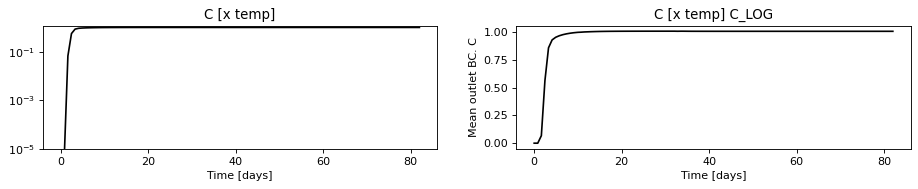

In [42]:
fig = plt.figure(figsize=(14, 2), dpi=80)               ; CD=[conc[:,0,:,-1]]         ; C_MEAN=np.transpose(np.mean(CD, axis=2))
ax=fig.add_subplot(121) ; plt.plot(times, C_MEAN,'k')   ; plt.xlabel('Time [days]')   ; plt.yscale('log')  ; plt.ylim([1E-5, 1.2]) ;plt.title("C [x temp]")
ax=fig.add_subplot(122) ; plt.plot(times, C_MEAN,'k')   ; plt.xlabel('Time [days]')   ; plt.ylabel('Mean outlet BC. C')            ;plt.title("C [x temp] C_LOG")   ;plt.show()

In [ ]:
print('conc.shape:',conc.shape); print('conc[ 12,:,0,:]:',conc[ 12,:,0,:].shape)  ; print(conc.shape[0])

conc.shape: (103, 20, 1, 40)
conc[ 12,:,0,:]: (20, 40)


103

In [54]:
pd.DataFrame(times).to_csv (TB/"times.csv")                 ; print('PERLEN:',np.cumsum(PERLEN))                                       ; print('max:',C_MEAN.max(),'min:', C_MEAN.min())  
pd.DataFrame(conc[ 12,:,0,:]).to_csv(TB/'CONC_12.csv')      ; pd.DataFrame(conc[ 50,:,0,:]).to_csv(TB/'CONC_50.csv')                   # print(times.shape) 
pd.DataFrame(conc[102,:,0,:]).to_csv(TB/'CONC_102.csv')     ; pd.DataFrame(conc.reshape(conc.shape[0],-1).T).to_csv(TB/"C_all[0].csv")   # _________________ conc.reshape _________________


PERLEN=[10,22,50] ; NPER=len(PERLEN) ;NPRS = 100   ;TIMPRS=np.linspace(0,np.sum(PERLEN),NPRS,endpoint=False)    ;itmuni=4;MT_tunit='D';lenuni=2;MT_lunit='M' 
NPER; #print(np.sum(PERLEN), list(TIMPRS))

pd.DataFrame(WF_S[0]).to_csv(TB/'WF_S.csv') ; pd.DataFrame(WT_S[0]).to_csv(TB/'WT_S.csv') ; print(C_MEAN.tolist())

PERLEN: [10 32 82]
max: 1.0061793 min: 0.0
[[0.0], [5.191386662772857e-06], [0.06730116903781891], [0.5628776550292969], [0.856901228427887], [0.9276944994926453], [0.951386034488678], [0.9651422500610352], [0.9749169945716858], [0.9821953177452087], [0.9877669811248779], [0.9920437335968018], [0.9953106641769409], [0.9958516359329224], [0.9970692992210388], [0.9992554783821106], [1.0005050897598267], [1.0017224550247192], [1.0027142763137817], [1.0034804344177246], [1.004075527191162], [1.00453519821167], [1.0048960447311401], [1.0051766633987427], [1.0053930282592773], [1.0055627822875977], [1.0056949853897095], [1.005797266960144], [1.0058763027191162], [1.0059380531311035], [1.005985975265503], [1.0060228109359741], [1.0060515403747559], [1.0060734748840332], [1.0060913562774658], [1.0061043500900269], [1.0061149597167969], [1.0061227083206177], [1.0061286687850952], [1.0061339139938354], [1.006137728691101], [1.0061793327331543], [1.0055428743362427], [1.0060536861419678], [1.0058